<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-07-18 23:11:23 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Conda ─────────── v1.10.2
   Installed VersionParsing ── v1.3.0
   Installed PyCall ────────── v1.96.4
   Installed MacroTools ────── v0.5.13
   Installed Parsers ───────── v2.8.1
   Installed Preferences ───── v1.4.3
   Installed JSON ──────────── v0.21.4
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.7 MB/s eta 0:00:00


In [3]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.6 MB/s eta 0:00:00


In [4]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
# pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ~1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [46]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pickle


In [378]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [379]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [380]:
df = df[(df['n_r2'] >= 0.05)]
print(df)

                                       model  skew girderName    L   D  \
0             Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28   42  28   
1            Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28   42  28   
8             Tx28-L_42-Nb_4-S_90-O_15-ts_85     0       Tx28   42  28   
9            Tx28-L_42-Nb_4-S_90-O_15-ts_100     0       Tx28   42  28   
17          Tx28-L_42-Nb_4-S_120-O_15-ts_100     0       Tx28   42  28   
...                                      ...   ...        ...  ...  ..   
5755   Tx84-L_210-Nb_7-S_90-O_45-ts_85-sk_60    60       Tx84  210  84   
5756  Tx84-L_210-Nb_7-S_120-O_24-ts_85-sk_60    60       Tx84  210  84   
5757  Tx84-L_210-Nb_7-S_120-O_36-ts_85-sk_60    60       Tx84  210  84   
5758  Tx84-L_210-Nb_7-S_120-O_48-ts_85-sk_60    60       Tx84  210  84   
5759  Tx84-L_210-Nb_7-S_120-O_60-ts_85-sk_60    60       Tx84  210  84   

          w_oh    ts   S  Nb            Kg  ...     n_bm4      n_r1      n_r2  \
0     1.500000   8.5   6   4  

In [381]:
df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']

girderName = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'girderName'].values
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values * np.pi / 180
O = (w_oh * 10).astype(int)
tss = (ts * 10).astype(int)
models = girderName + '-L_' + L.astype(str) + '-Nb_' + Nb.astype(str) + '-S_' + (S*10).astype(str) + '-O_' + O.astype(str) + '-ts_' + tss.astype(str)
print(models)
skews = [30, 45, 60]
sk_bm1_correction,sk_bm2_correction, sk_r1_correction, sk_r2_correction  = [], [], [], [],
x_L, x_S, x_D, x_Nb, x_skew, x_w_oh, x_trial, x_tan_skew, x_AR = [], [], [], [], [], [], [], [], []

for skew in skews:
  for model in models:
    skew_model = model + '-sk_' + str(skew)
    normal_model = model
    n_bm1_skewed = df.loc[(df['model'] == skew_model) , 'n_bm1'].values
    n_bm1_normal = df.loc[(df['model'] == normal_model) , 'n_bm1'].values
    n_bm2_skewed = df.loc[(df['model'] == skew_model) , 'n_bm2'].values
    n_bm2_normal = df.loc[(df['model'] == normal_model) , 'n_bm2'].values
    n_r1_skewed = df.loc[(df['model'] == skew_model) , 'n_r1'].values
    n_r1_normal = df.loc[(df['model'] == normal_model) , 'n_r1'].values
    n_r2_skewed = df.loc[(df['model'] == skew_model) , 'n_r2'].values
    n_r2_normal = df.loc[(df['model'] == normal_model) , 'n_r2'].values
    sk_bm1_correction.extend(n_bm1_skewed / n_bm1_normal)
    sk_bm2_correction.extend(n_bm2_skewed / n_bm2_normal)
    sk_r1_correction.extend(n_r1_skewed / n_r1_normal)
    sk_r2_correction.extend(n_r2_skewed / n_r2_normal)
    x_L.extend(df.loc[(df['model'] == skew_model) , 'L'].values)
    x_S.extend(df.loc[(df['model'] == skew_model) , 'S'].values)
    x_D.extend(df.loc[(df['model'] == skew_model) , 'D'].values)
    x_Nb.extend(df.loc[(df['model'] == skew_model) , 'Nb'].values)
    x_skew.extend(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180)
    # x_tan_skew.extend(np.tan(df.loc[(df['model'] == skew_model) , 'skew'].values * np.pi / 180))
    x_w_oh.extend(df.loc[(df['model'] == skew_model) , 'w_oh'].values)
    x_trial.extend(df.loc[(df['model'] == skew_model) , 'x_trial'].values)


['Tx28-L_42-Nb_4-S_60-O_15-ts_85' 'Tx28-L_42-Nb_4-S_90-O_15-ts_85'
 'Tx28-L_56-Nb_4-S_60-O_15-ts_85' 'Tx28-L_56-Nb_4-S_60-O_20-ts_85'
 'Tx28-L_56-Nb_4-S_90-O_15-ts_85' 'Tx28-L_56-Nb_4-S_90-O_21-ts_85'
 'Tx28-L_56-Nb_4-S_120-O_15-ts_85' 'Tx28-L_70-Nb_4-S_60-O_15-ts_85'
 'Tx28-L_70-Nb_4-S_60-O_20-ts_85' 'Tx28-L_70-Nb_4-S_90-O_15-ts_85'
 'Tx28-L_70-Nb_4-S_90-O_21-ts_85' 'Tx28-L_70-Nb_4-S_120-O_15-ts_85'
 'Tx28-L_70-Nb_4-S_120-O_21-ts_85' 'Tx34-L_51-Nb_4-S_60-O_15-ts_85'
 'Tx34-L_51-Nb_4-S_90-O_15-ts_85' 'Tx34-L_51-Nb_4-S_120-O_15-ts_85'
 'Tx34-L_68-Nb_4-S_60-O_15-ts_85' 'Tx34-L_68-Nb_4-S_60-O_20-ts_85'
 'Tx34-L_68-Nb_4-S_90-O_15-ts_85' 'Tx34-L_68-Nb_4-S_90-O_24-ts_85'
 'Tx34-L_68-Nb_4-S_120-O_15-ts_85' 'Tx34-L_85-Nb_4-S_60-O_15-ts_85'
 'Tx34-L_85-Nb_4-S_60-O_20-ts_85' 'Tx34-L_85-Nb_4-S_90-O_15-ts_85'
 'Tx34-L_85-Nb_4-S_90-O_24-ts_85' 'Tx34-L_85-Nb_4-S_120-O_15-ts_85'
 'Tx34-L_85-Nb_4-S_120-O_24-ts_85' 'Tx40-L_60-Nb_4-S_60-O_15-ts_85'
 'Tx40-L_60-Nb_4-S_60-O_20-ts_85' 'Tx40-L_60-Nb_4-S_90-

In [382]:
x_tan_skew = np.tan(x_skew)
x_cos_skew = np.cos(x_skew)
x_sin_skew = np.sin(x_skew)
print(sk_r1_correction[2304:])
print(x_skew)
print(x_tan_skew)

[]
[0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0.52359877559829

In [383]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew,x_D), axis=-1)
y = sk_r2_correction
print(X.shape)
print(len(y))
print(X)
print(y)

(1914, 5)
1914
[[ 42.           6.           1.5          0.57735027  28.        ]
 [ 42.           9.           1.5          0.57735027  28.        ]
 [ 56.           6.           1.5          0.57735027  28.        ]
 ...
 [210.          12.           2.41666667   1.73205081  84.        ]
 [210.          12.           3.61111111   1.73205081  84.        ]
 [210.          12.           4.80555556   1.73205081  84.        ]]
[3.007646295140231, 2.5902037996930676, 3.0293130755985445, 4.940407647226895, 2.550730147336772, 3.9572487659286963, 2.3398385195762184, 3.1521892980913573, 4.624529342224393, 2.603489127590139, 3.4587785116064445, 2.3806420185430452, 2.961634054815223, 2.6620715648113684, 2.3927340983082797, 2.271163335614376, 2.7271299538268305, 3.918773705046482, 2.3747515835131834, 4.1445965236375875, 2.2122637905628513, 2.880078589521048, 3.9141360314891465, 2.4293826583844336, 3.45824053765908, 2.2455571524850533, 2.9476720590949315, 2.4035487679473806, 3.6454736312905776, 2

In [384]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=200,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/'],
    unary_operators=["square", "sqrt"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-4,4),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:915: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(


In [385]:
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.700e+02
Head worker occupation: 76.6%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 10 / 10000 total iterations (0.100%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           8.128e+00  7.971e+00  y = sqrt(x₃)
3           1.383e+00  1.771e+00  y = 1.3396 + x₂
5           1.265e+00  4.474e-02  y = x₃ + (-0.093912 - -2.573)
7           8.980e-01  1.712e-01  y = (x₃ + 4.6162) + (-4.3632 / x₂)
8           8.930e-01  5.537e-03  y = (1.3396 + (sqrt(x₃) * x₂)) + 0.1467
9           8.029e-01  1.064e-01  y = sqrt(x₂ / (0.8361 / x₃)) / square(0.68936)
14          7.954e-01  1.875e-03  y = (sqrt(x₂ / sqrt(sqrt(0.30474) / square(x₃))) / square(0.68...
                                  936)) + -0.14325
15          7.707e-01  3.154e-02  y = ((sqrt(x₃) * x₂) + sqrt(x₃

In [405]:
n = 9
model.sympy(n)


x2*sqrt(x3)*(0.6688581 + 361.84183/(x1*x4))

In [406]:
y_pred = model.predict(X,n)
print("Default selection MSE:", np.power(y_pred - y, 2).mean())
r2 = r2_score(y_pred, y)
print(f"R²: {r2:.4f}")

Default selection MSE: 0.21683015350199192
R²: 0.8732


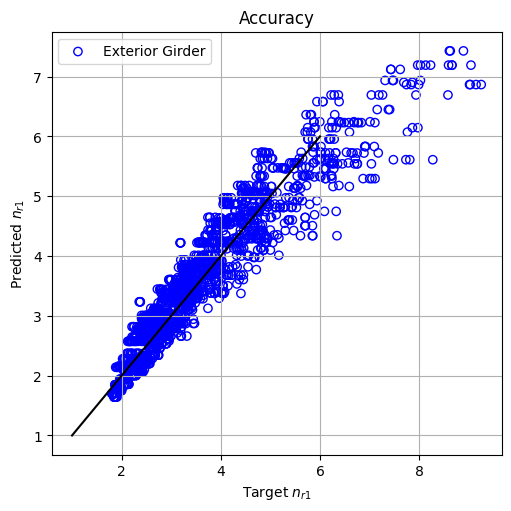

In [404]:
x_line = [1, 6]
y_line = [1, 6]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
# plt.xlim((0.9,1.8))
# plt.ylim((0.9,1.8))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [280]:
print(y_pred)

[3.30750861 2.70056947 2.86438648 ... 2.91868417 4.36125221 5.80382025]


In [ ]:
for i in range(10):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  r2 = r2_score(y_pred, y)
  print(f"R²: {r2:.4f}")
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [ ]:
# save the  as a pickle file
model_pkl_file = "skew_correction_V_G1.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate model
y_predict = model.predict(X,n)

# check results
print(y_predict)

[1.09735977 1.07267283 1.05582327 ... 1.12907411 1.10970617 1.09691723]


In [ ]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_r2_correction
model.fit(X, y)
print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.090e+04
Head worker occupation: 14.9%
Progress: 47 / 20000 total iterations (0.235%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           6.745e+03  7.971e+00  y = sqrt(0.16452)
3           6.743e+03  2.558e-04  y = 1.8208 - x₂
4           6.741e+03  3.384e-04  y = square(1.7956) - x₂
5           6.741e+03  5.960e-07  y = 0.58728 - (x₂ - 2.6573)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.210e+04
Head worker occupation: 11.8%
Progress: 124 / 20000 total iterations (0.620%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.746e+03  1.594e+01  y = 1.225
2           6.745e+03  1.

In [ ]:
for i in range(10):
  print(model.sympy(i))
  y_pred = model.predict(X,i)
  print("Default selection MSE:", np.power(y_pred - y, 2).mean())
  r2 = r2_score(y_pred, y)
  print(f"R²: {r2:.4f}")
  x_line = [0.9, 1.8]
  y_line = [0.9, 1.8]
  fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)
  ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
  ax1.plot(x_line, y_line, c = "k")
  ax1.set_title('Accuracy')
  ax1.legend()
  plt.xlim((0.9,1.8))
  plt.ylim((0.9,1.8))
  ax1.set_xlabel('Target $n_{r1}$')
  ax1.set_ylabel('Predicted $n_{r1}$')
  ax1.grid()

In [ ]:
model_pkl_file = "skew_correction_V_G2.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_bm1_correction
model.fit(X, y)
print(model)

In [ ]:
model_pkl_file = "skew_correction_M_G1.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
X = np.stack((x_L, x_S, x_w_oh, x_tan_skew), axis=-1)
y = sk_bm2_correction
model.fit(X, y)
print(model)

In [ ]:
model_pkl_file = "skew_correction_M_G2.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)